### Отток клиентов банка

Источник датасета https://www.kaggle.com/datasets/adammaus/predicting-churn-for-bank-customers

Необходимо 
1. исследовать данные, 
2. подобрать лучшую модель для предсказания оттока клиентов банка, 
3. сделать оценку экономической эффективности использования модели при условии: удержание клиента стоит 1 доллар, прибыль в случае удержания правильно определенного "уходящего" клиента 2 доллара.

#### Загружаем библиотеки и датасет

In [319]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [320]:
pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [321]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import phik
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [322]:
df = pd.read_csv('/Users/Alisa/Downloads/churn_data.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


#### Предварительно исследуем датасет: 
проверим пропуски и дубли, исследуем соотношение классов. 

In [323]:
df.info()  # общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


Видим, что пропусков нет, так как во всех колонках 10000 non-null значений

In [324]:
df.describe(include='all') # основные статистические характеристики

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000,10000.000000,10000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,2932,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Smith,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,32,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,5000.50000,1.569094e+07,NaN,650.528800,NaN,NaN,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,NaN,96.653299,NaN,NaN,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,NaN,350.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,NaN,584.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,NaN,652.000000,NaN,NaN,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,NaN,718.000000,NaN,NaN,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000


In [325]:
df.nunique () # посмотрим количество уникальных значений

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

RowNumber и CustomerID, являясь уникальными для каждой строки, дублруют индексы. Их можно удалить, также удалим фамилии. 

In [326]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [327]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [328]:
df.duplicated().sum() # проверим дубли

0

In [329]:
df['Exited'].value_counts() # проверим соотношение классов

0    7963
1    2037
Name: Exited, dtype: int64

Присутствует дисбаланс классов, который мы впоследствии исправим. 

#### Исследовательский анализ данных

Построим матрицу корреляции признаков

interval columns not set, guessing: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


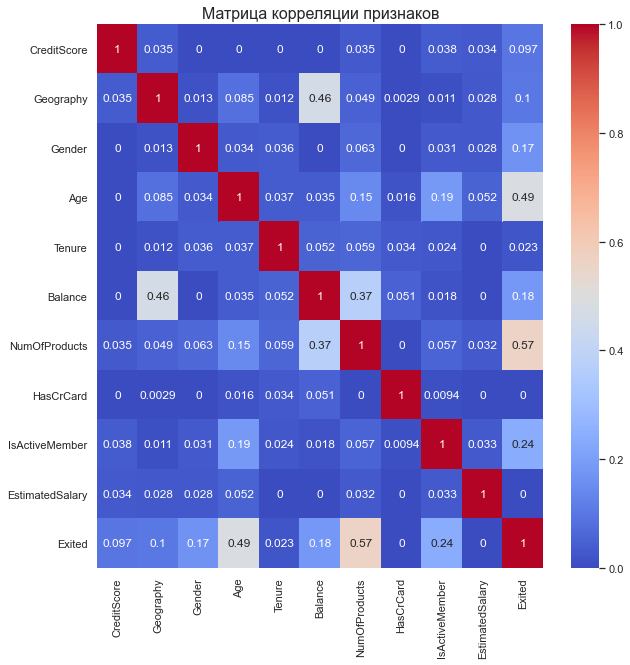

In [330]:
phik = df.phik_matrix()
sns.set(rc={'figure.figsize':(10,10)})
plt.title('Матрица корреляции признаков', size=16)
sns.heatmap(phik, annot=True, cmap='coolwarm');

Можно обнаружить корреляцию между количеством продуктов (NumOfProducts) и высокой вероятностью ухода клиента.
Между признаками нет сильной корреляции, которая привела бы к проблеме мультиколлинеарности.

Сравним профиль ушедших и оставшихся клиентов по некоторым признакам

#### Кредитный рейтинг

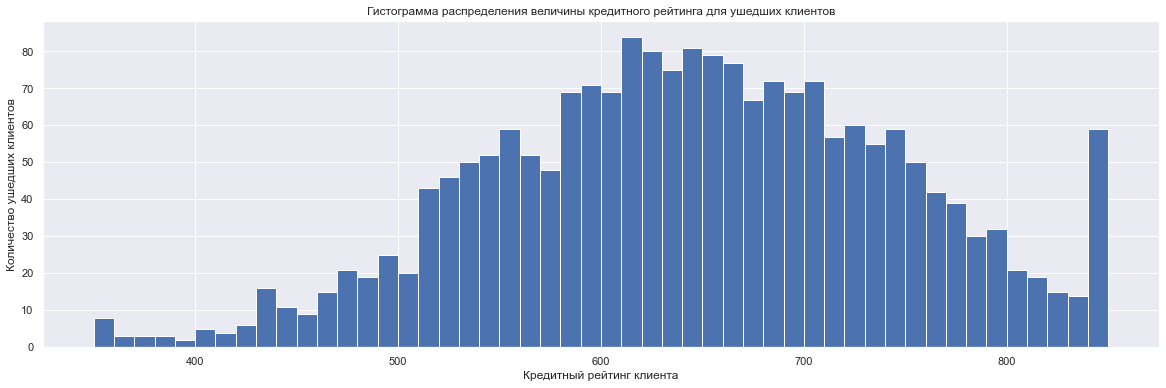

In [331]:
plt.figure(figsize=(20,6))
plt.title('Гистограмма распределения величины кредитного рейтинга для ушедших клиентов')
plt.xlabel('Кредитный рейтинг клиента')
plt.ylabel('Количество ушедших клиентов')
df.loc[df['Exited'] == 1]['CreditScore'].hist(bins=50)
plt.show();

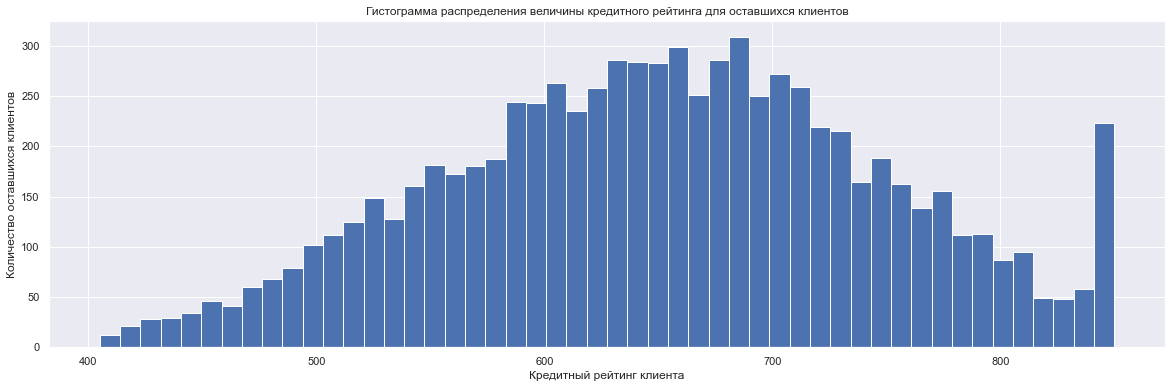

In [332]:
plt.figure(figsize=(20,6))
plt.title('Гистограмма распределения величины кредитного рейтинга для оставшихся клиентов')
plt.xlabel('Кредитный рейтинг клиента')
plt.ylabel('Количество оставшихся клиентов')
df.loc[df['Exited'] == 0]['CreditScore'].hist(bins=50)
plt.show();

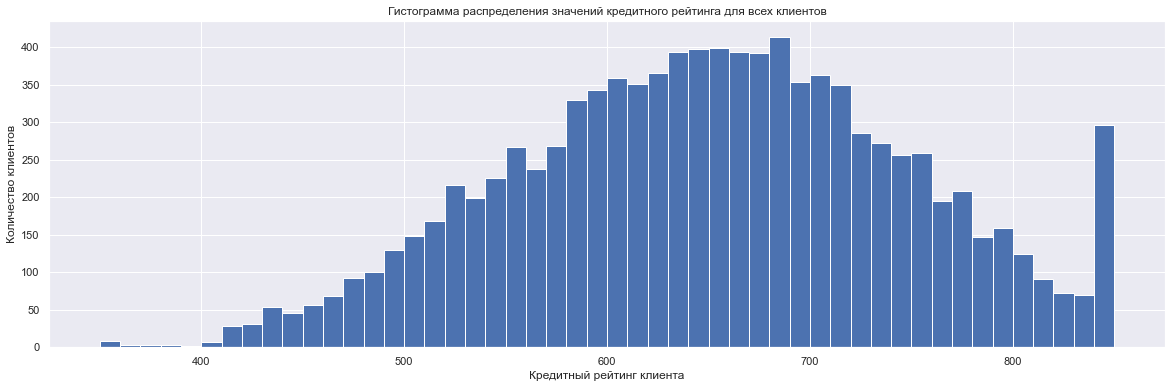

In [333]:
plt.figure(figsize=(20,6))
plt.title('Гистограмма распределения значений кредитного рейтинга для всех клиентов')
plt.xlabel('Кредитный рейтинг клиента')
plt.ylabel('Количество клиентов')
df['CreditScore'].hist(bins=50)
plt.show();

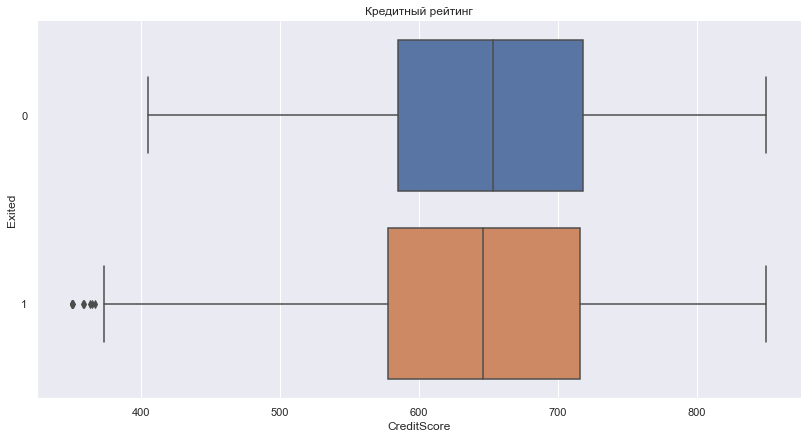

In [334]:
total = sns.catplot(data = df, y='Exited', x='CreditScore', kind="box", orient='h')
total.fig.set_figwidth(12)
total.fig.set_figheight(6)
plt.title('Кредитный рейтинг')
plt.show();

По признаку Credit Score профиль учешдших и оставшихся клиентов отличается незначительно. Среди ушедших клиентов есть некоторое число клиентов с низким кредитным рейтингом (который составляет < 400 пунктов).

#### Баланс на счете

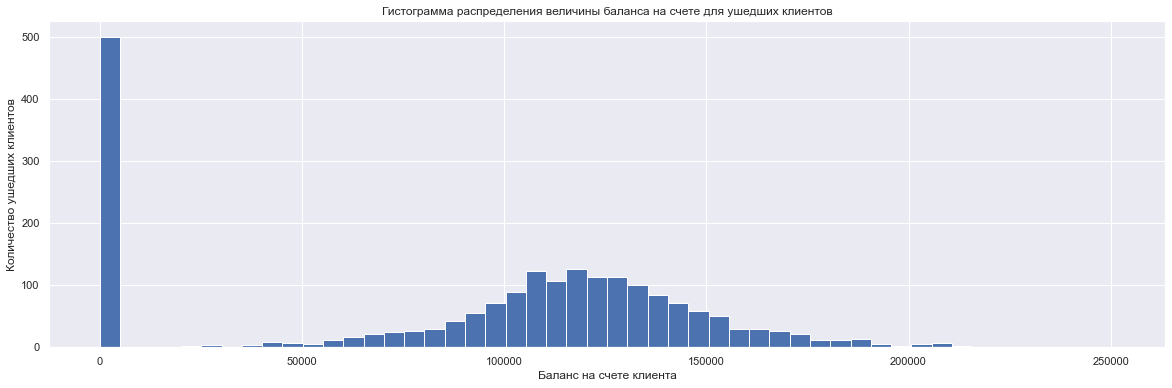

In [335]:
plt.figure(figsize=(20,6))
plt.title('Гистограмма распределения величины баланса на счете для ушедших клиентов')
plt.xlabel('Баланс на счете клиента')
plt.ylabel('Количество ушедших клиентов')
df.loc[df['Exited'] == 1]['Balance'].hist(bins=50)
plt.show();

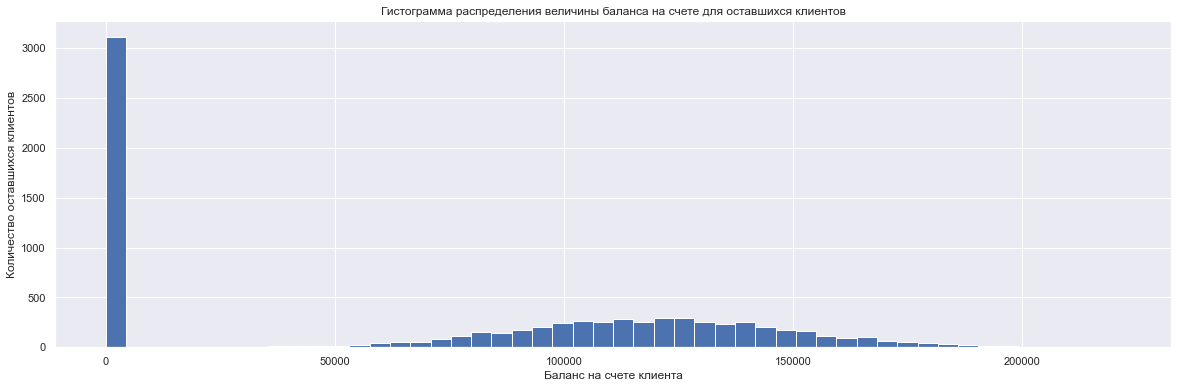

In [336]:
plt.figure(figsize=(20,6))
plt.title('Гистограмма распределения величины баланса на счете для оставшихся клиентов')
plt.xlabel('Баланс на счете клиента')
plt.ylabel('Количество оставшихся клиентов')
df.loc[df['Exited'] == 0]['Balance'].hist(bins=50)
plt.show();

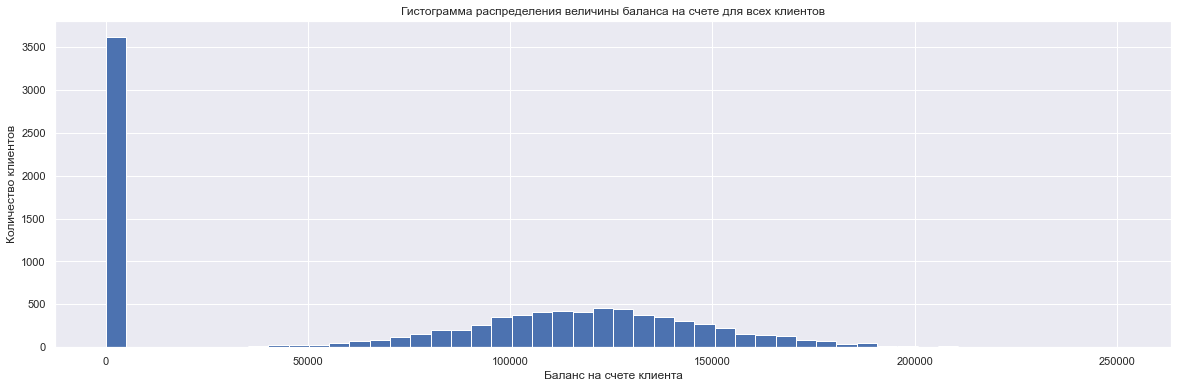

In [337]:
plt.figure(figsize=(20,6))
plt.title('Гистограмма распределения величины баланса на счете для всех клиентов')
plt.xlabel('Баланс на счете клиента')
plt.ylabel('Количество клиентов')
df['Balance'].hist(bins=50)
plt.show();

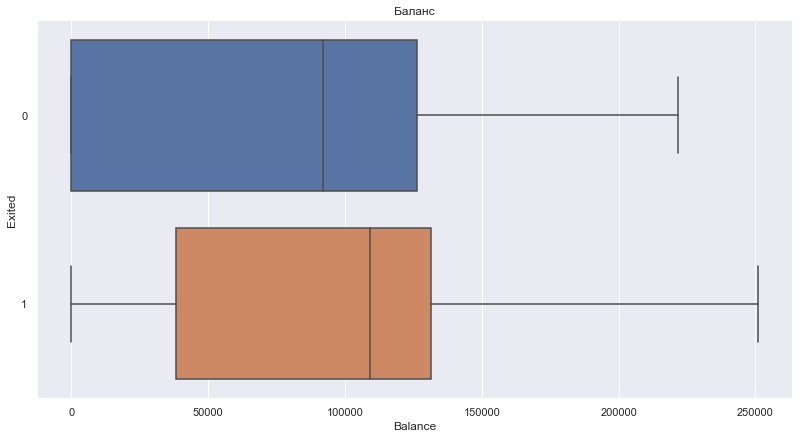

In [338]:
total = sns.catplot(data = df, y='Exited', x='Balance', kind="box", orient='h')
total.fig.set_figwidth(12)
total.fig.set_figheight(6)
plt.title('Баланс')
plt.show();

По Balance ушедшие и оставшиеся клиенты не очень различаются. Среди оставшихся клиентов есть некоторое число клиентов с нулевым балансом, которые не являются активными, поэтому не уходят. Хотя по гистограммам видны также клиенты с небольшим балансом, склонные уйти. 

#### Исправим дисбаланс классов

In [339]:
df_0 = df.loc[df['Exited'] == 0]
df_0 = df_0.sample(2037)
df_1 = df.loc[df['Exited'] == 1]

In [340]:
frames = [df_0, df_1]
df = pd.concat(frames)
df = df.sample(frac = 1, random_state = 1)

Посмотрим на соотношение ушедших и оставшихся клиентов по некоторым категориальным признакам. Эти гистограммы очень несовершенны, так как мы отбросили большую часть данных, чтобы выровнять дисбаланс классов.

In [341]:
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

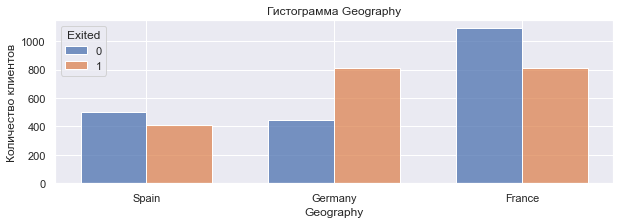

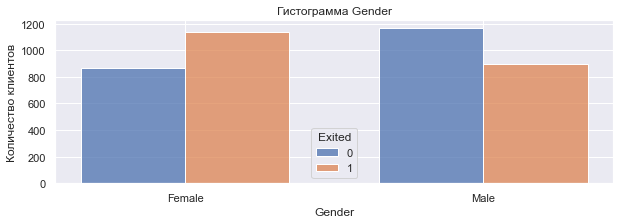

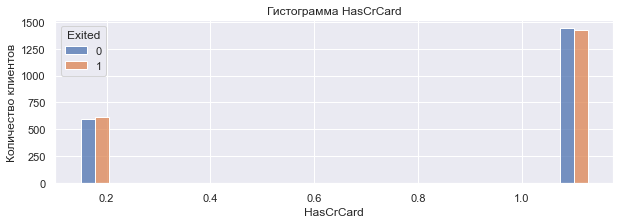

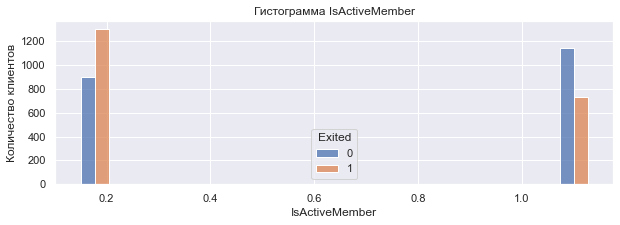

In [342]:
for i in categorical_features:
    plt.figure(figsize=(10,3))
    plt.ylabel('Количество клиентов')
    plt.xlabel(i)
    plt.title(f'Гистограмма {i}')
    sns.histplot(data=df, x=i, hue='Exited', multiple='dodge', shrink=0.7)
    plt.show();

Обращает на себя внимание количество ушедших клиентво в Германии.  

#### Обучение

Делим на train, test и val-выборки

In [343]:
X = df.drop(columns=['Exited'])
y = df['Exited']

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 0)

In [345]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size = 0.7, random_state = 0)

Собираем Pipeline для обработки таблицы признаков: признаки у нас категориальные и количественные (непрерывные). Категориальные переменные будем кодировать OneHotEncoder (в виде разреженной матрицы 0 и 1)

In [346]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [347]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [348]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [349]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [350]:
models_results = {
    'model_type': [],
    'threshold': [],
    'f_score': [],
    'precision': [],
    'recall': [],
}

Осуществим предсказание разными моделями CatBoost, XGBoost, GBM, также для сравнения используем логистическую регрессию (для нее мы приведем признаки к единому масштабу в отдельном пайплайне). Для лучшей модели сделаем матрицу ошибок. 

**1. CatBoostclassifier**

In [351]:
from catboost import CatBoostClassifier

In [352]:
catboost_pipeline = Pipeline([
    ('features', feats),
    ('catboost_classifier', CatBoostClassifier(iterations=25, random_state=42)),
])

In [353]:
catboost_pipeline.fit(X_train, y_train)

Learning rate set to 0.474577
0:	learn: 0.5532217	total: 4.72ms	remaining: 113ms
1:	learn: 0.5044809	total: 9.64ms	remaining: 111ms
2:	learn: 0.4711929	total: 14.9ms	remaining: 110ms
3:	learn: 0.4604927	total: 19.8ms	remaining: 104ms
4:	learn: 0.4439438	total: 28.1ms	remaining: 113ms
5:	learn: 0.4358140	total: 33.7ms	remaining: 107ms
6:	learn: 0.4327778	total: 37.7ms	remaining: 97ms
7:	learn: 0.4233290	total: 42.7ms	remaining: 90.7ms
8:	learn: 0.4200692	total: 47.6ms	remaining: 84.5ms
9:	learn: 0.4151109	total: 52.9ms	remaining: 79.4ms
10:	learn: 0.4126457	total: 57.8ms	remaining: 73.6ms
11:	learn: 0.4028908	total: 62.9ms	remaining: 68.2ms
12:	learn: 0.3988282	total: 68.2ms	remaining: 62.9ms
13:	learn: 0.3897807	total: 73.3ms	remaining: 57.6ms
14:	learn: 0.3823897	total: 78.7ms	remaining: 52.5ms
15:	learn: 0.3777335	total: 83.8ms	remaining: 47.1ms
16:	learn: 0.3750926	total: 88.9ms	remaining: 41.9ms
17:	learn: 0.3704207	total: 94.1ms	remaining: 36.6ms
18:	learn: 0.3652652	total: 99ms	r

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [354]:
preds = catboost_pipeline.predict_proba(X_test)[:, 1]

In [355]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [356]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.38585123813732014, F-Score=0.784, Precision=0.759, Recall=0.811


In [357]:
models_results['model_type'].append('CatBoost')
models_results['threshold'].append(thresholds[ix])
models_results['f_score'].append(fscore[ix])
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])

**2. XGB**

In [358]:
pip install xgboost -q

Note: you may need to restart the kernel to use updated packages.


In [359]:
import xgboost as xgb

params = {
    'max_depth': 4,
    'eta': 0.01,
    'subsample': 0.4,
    'min_child_weight': 5,
    'n': 50,
}

In [360]:
xgb_pipeline = Pipeline([
    ('features', feats),
    ('xgboost_classifier', xgb.XGBClassifier(boosting_type='gbdt', **params)),
])

In [361]:
xgb_pipeline.fit(X_train, y_train)

[20:44:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "boosting_type", "n" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [362]:
preds = xgb_pipeline.predict_proba(X_test)[:, 1]

In [363]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4295540452003479, F-Score=0.782, Precision=0.715, Recall=0.862


In [364]:
models_results['model_type'].append('XGB')
models_results['threshold'].append(thresholds[ix])
models_results['f_score'].append(fscore[ix])
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])

**3. GBM**

In [365]:
from sklearn.ensemble import GradientBoostingClassifier

params_est = {
    'n_estimators': 50,
    'loss': 'exponential',
    'learning_rate': 0.05,
    'subsample': 0.4,
    'min_samples_leaf': 3,
    'random_state': 1,
}

In [366]:
gb_pipeline = Pipeline([
    ('features', feats),
    ('gb_boost_classifier', GradientBoostingClassifier(**params_est)),
])

In [367]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [368]:
preds = gb_pipeline.predict_proba(X_test)[:, 1]

In [369]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4054314236239039, F-Score=0.795, Precision=0.751, Recall=0.846


In [370]:
models_results['model_type'].append('gbm')
models_results['threshold'].append(thresholds[ix])
models_results['f_score'].append(fscore[ix])
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])

#### 4. Логистическая регрессия
Для нее добавим в пайплайн масштабирование данных при помощи StandardScaler

In [371]:
from sklearn.preprocessing import StandardScaler

In [372]:
final_transformers_sc = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers_sc.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    
    final_transformers_sc.append((cont_col, cont_transformer))

In [373]:
feats_sc = FeatureUnion(final_transformers_sc)

feature_processing_sc = Pipeline([('feats_sc', feats_sc)])

In [374]:
lr_pipeline = Pipeline([
    ('features', feats_sc),
    ('LogisticRegression', LogisticRegression(random_state=42)),
])

In [375]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [376]:
preds = lr_pipeline.predict_proba(X_test)[:, 1]

In [377]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [378]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [379]:
fscore = (2 * precision * recall) / (precision + recall)

In [380]:
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.37087015225520686, F-Score=0.744, Precision=0.649, Recall=0.871


In [381]:
models_results['model_type'].append('LR')
models_results['threshold'].append(thresholds[ix])
models_results['f_score'].append(fscore[ix])
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])

Сравниваем результаты

In [382]:
models_results = pd.DataFrame(models_results)
models_results

,model_type,threshold,f_score,precision,recall
0,CatBoost,0.385851,0.783964,0.758621,0.811060
1,XGB,0.429554,0.781609,0.715105,0.861751
2,gbm,0.405431,0.795233,0.750511,0.845622
3,LR,0.370870,0.744094,0.649485,0.870968


Наверное, самая подходящая метрика здесь f_score (гармоническое среднее точности и полноты), так как в этой задаче и потеря клиента, и удержание клиента дорого стоит. Выбираем модель GBM

#### Оценка экономической эффективности модели 

По условиям задания удержание клиента стоит 1 доллар, прибыль в случае удержания правильно определенного "уходящего" клиента 2 доллара. Оценим эффективность использования модели на валидационной выборке

In [433]:
preds = gb_pipeline.predict_proba(X_val)[:, 1]

In [434]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.39635464027980777, F-Score=0.785, Precision=0.728, Recall=0.852


Построим матрицу ошибок

In [435]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[135  56]
 [ 27 149]]


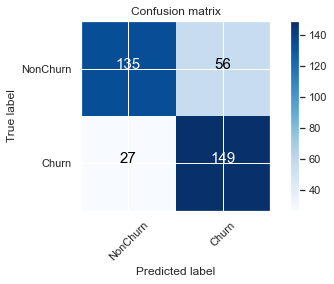

In [436]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Стоимость удержания клиентов: retain_sum
Прибыль при удержании "уходящих": income

In [437]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

93

In [438]:
X_val.shape

(367, 10)

Таким образом, выгода от использования модели на данной небольшой выборке - 367 клиентов - составит 93 доллара